In [1]:
#!pip install pandas numpy matplotlib seaborn plotly tabulate lightgbm xgboost scikit-learn tensorflow keras


In [2]:

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tabulate import tabulate
import plotly.graph_objects as go
import plotly.colors as pc
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
import random
import os
from tensorflow.keras.regularizers import l2

In [3]:

# Reading the datasets
calendar = pd.read_csv("calendar.csv")
sales = pd.read_csv("sales_train_evaluation.csv")
prices = pd.read_csv("sell_prices.csv")


In [4]:
# first 5 rows of calender
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [5]:
sales.head()
# prices.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [6]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


# Datasets joining procedure
## calendar.csv:

Key column: d (maps to day columns in sales_train_evaluation.csv).
Secondary column: wm_yr_wk (maps to wm_yr_wk in sell_prices.csv).

## sales_train_evaluation.csv:

Key columns: id, item_id, store_id, state_id`.
Daily columns: d_1, d_2, ... d_1913 need to be reshaped (melted) to match the calendar.csv date structure.

## sell_prices.csv:

Key columns: store_id, item_id, wm_yr_wk`.

In [7]:

# 2. coverting date column
calendar['date'] = pd.to_datetime(calendar['date'])

# Checking missing values
print("Missing values in Calendar:", calendar.isnull().sum())
print("Missing values in Sales:", sales.isnull().sum())
print("Missing values in Prices:", prices.isnull().sum())



Missing values in Calendar: date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64
Missing values in Sales: id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1909      0
d_1910      0
d_1911      0
d_1912      0
d_1913      0
Length: 1919, dtype: int64
Missing values in Prices: store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64


In [8]:

# chose Texas data as per question
sales_tx = sales[sales['state_id'] == 'TX']
sales_tx

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
12196,HOBBIES_1_001_TX_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,0,0,0,0,...,0,0,0,0,1,0,1,0,0,2
12197,HOBBIES_1_002_TX_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,TX_1,TX,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12198,HOBBIES_1_003_TX_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,TX_1,TX,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12199,HOBBIES_1_004_TX_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX,1,2,1,0,...,0,3,2,0,1,0,0,0,2,2
12200,HOBBIES_1_005_TX_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,TX_1,TX,0,0,0,0,...,1,2,2,0,0,2,3,0,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21338,FOODS_3_823_TX_3_evaluation,FOODS_3_823,FOODS_3,FOODS,TX_3,TX,0,0,0,0,...,1,1,0,1,0,0,0,2,0,2
21339,FOODS_3_824_TX_3_evaluation,FOODS_3_824,FOODS_3,FOODS,TX_3,TX,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
21340,FOODS_3_825_TX_3_evaluation,FOODS_3_825,FOODS_3,FOODS,TX_3,TX,0,0,0,2,...,1,1,1,3,1,0,0,4,2,0
21341,FOODS_3_826_TX_3_evaluation,FOODS_3_826,FOODS_3,FOODS,TX_3,TX,0,0,0,0,...,0,2,1,1,5,3,1,2,1,2


In [9]:

# Reshaping sales data and Melting  based on these columns'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d','sales'
sales_melted = pd.melt(sales,
                       id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                       var_name='d',
                       value_name='sales')



In [10]:
sales_melted

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
...,...,...,...,...,...,...,...,...
58327365,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1913,1
58327366,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1913,0
58327367,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1913,0
58327368,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1913,3


In [11]:
# Merging calendar dataset with sales dataset
sales_with_calendar = sales_melted.merge(calendar, on='d', how='left')

In [12]:
sales_with_calendar.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [13]:
# Filtering rows where event_name_1 , event_type_1, event_name_2 , event_type_2 is not null
events_present = sales_with_calendar[
    (sales_with_calendar['event_name_1'].notnull()) |
    (sales_with_calendar['event_type_1'].notnull()) |
    (sales_with_calendar['event_name_2'].notnull()) |
    (sales_with_calendar['event_type_2'].notnull())
]

# first few rows where events are not null
events_present


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
243920,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_9,0,2011-02-06,11102,...,2,2,2011,SuperBowl,Sporting,NaN,NaN,1,1,1
243921,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_9,0,2011-02-06,11102,...,2,2,2011,SuperBowl,Sporting,NaN,NaN,1,1,1
243922,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_9,0,2011-02-06,11102,...,2,2,2011,SuperBowl,Sporting,NaN,NaN,1,1,1
243923,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_9,0,2011-02-06,11102,...,2,2,2011,SuperBowl,Sporting,NaN,NaN,1,1,1
243924,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_9,0,2011-02-06,11102,...,2,2,2011,SuperBowl,Sporting,NaN,NaN,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57473645,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1885,0,2016-03-27,11609,...,2,3,2016,Easter,Cultural,NaN,NaN,0,0,0
57473646,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1885,0,2016-03-27,11609,...,2,3,2016,Easter,Cultural,NaN,NaN,0,0,0
57473647,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1885,1,2016-03-27,11609,...,2,3,2016,Easter,Cultural,NaN,NaN,0,0,0
57473648,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1885,4,2016-03-27,11609,...,2,3,2016,Easter,Cultural,NaN,NaN,0,0,0


In [14]:

# Merging prices based on these columns 'store_id', 'item_id', 'wm_yr_wk'
sales_with_prices = sales_with_calendar.merge(prices,
                                              on=['store_id', 'item_id', 'wm_yr_wk'],
                                              how='left')




In [15]:
sales_with_prices.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


In [16]:
#Extracting sales data for item 'HOBBIES_1_001' during week 11325

hobby_1_11325 = sales_with_prices[
    (sales_with_prices['item_id'] == 'HOBBIES_1_001') &
    (sales_with_prices['wm_yr_wk'] == 11325)
]

hobby_1_11325

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
27319040,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_897,0,2013-07-13,11325,...,7,2013,NaN,NaN,NaN,NaN,0,1,0,9.58
27322089,HOBBIES_1_001_CA_2_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_2,CA,d_897,0,2013-07-13,11325,...,7,2013,NaN,NaN,NaN,NaN,0,1,0,NaN
27325138,HOBBIES_1_001_CA_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,d_897,0,2013-07-13,11325,...,7,2013,NaN,NaN,NaN,NaN,0,1,0,NaN
27328187,HOBBIES_1_001_CA_4_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_4,CA,d_897,0,2013-07-13,11325,...,7,2013,NaN,NaN,NaN,NaN,0,1,0,9.58
27331236,HOBBIES_1_001_TX_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,d_897,0,2013-07-13,11325,...,7,2013,NaN,NaN,NaN,NaN,0,1,0,9.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27517225,HOBBIES_1_001_TX_2_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_2,TX,d_903,0,2013-07-19,11325,...,7,2013,NaN,NaN,NaN,NaN,0,0,0,NaN
27520274,HOBBIES_1_001_TX_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_3,TX,d_903,0,2013-07-19,11325,...,7,2013,NaN,NaN,NaN,NaN,0,0,0,NaN
27523323,HOBBIES_1_001_WI_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_1,WI,d_903,0,2013-07-19,11325,...,7,2013,NaN,NaN,NaN,NaN,0,0,0,9.58
27526372,HOBBIES_1_001_WI_2_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_2,WI,d_903,0,2013-07-19,11325,...,7,2013,NaN,NaN,NaN,NaN,0,0,0,NaN


In [17]:
sales_with_prices['cat_id'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

In [18]:
sales_with_prices['dept_id'].unique()

array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object)

In [19]:
#Counting unique items per department and sorting by department ID

distinct_item_id_count = sales_with_prices.groupby('dept_id')['item_id'].nunique().sort_index()
distinct_item_id_count

,item_id
dept_id,
FOODS_1,216
FOODS_2,398
FOODS_3,823
HOBBIES_1,416
HOBBIES_2,149
HOUSEHOLD_1,532
HOUSEHOLD_2,515


In [20]:
distinct_store_id_count = sales_with_prices.groupby('state_id')['store_id'].nunique().sort_index()
distinct_store_id_count

,store_id
state_id,
CA,4
TX,3
WI,3


In [21]:

# 6. Feature Engineering
# Creating lag features for recent sales (Lag 7 and Lag 28)
sales_with_prices['lag_7'] = sales_with_prices.groupby(['id'])['sales'].shift(7)
sales_with_prices['lag_28'] = sales_with_prices.groupby(['id'])['sales'].shift(28)

# Moving Average Feature
sales_with_prices['rolling_mean_7'] = sales_with_prices.groupby(['id'])['sales'].shift(7).rolling(7).mean()

# Calendar dataset Features
sales_with_prices['day_of_week'] = sales_with_prices['date'].dt.dayofweek
sales_with_prices['month'] = sales_with_prices['date'].dt.month

# Price Features - Sell Price Difference
sales_with_prices['price_diff'] = sales_with_prices.groupby(['item_id'])['sell_price'].diff()

# Aggregating datasets for category-level and department-level sales
cat_forecast = sales_with_prices.groupby(['cat_id', 'date'])['sales'].sum().reset_index()
dept_forecast = sales_with_prices.groupby(['dept_id', 'date'])['sales'].sum().reset_index()


In [22]:
dept_forecast.head()

,dept_id,date,sales
0,FOODS_1,2011-01-29,2343
1,FOODS_1,2011-01-30,2216
2,FOODS_1,2011-01-31,1657
3,FOODS_1,2011-02-01,1508
4,FOODS_1,2011-02-02,1209


In [23]:
cat_forecast.head()

,cat_id,date,sales
0,FOODS,2011-01-29,23178
1,FOODS,2011-01-30,22758
2,FOODS,2011-01-31,17174
3,FOODS,2011-02-01,18878
4,FOODS,2011-02-02,14603


In [24]:

# Checking Final Dataset After Feature Engineering
print("Final Dataset with Feature Engineering:")
sales_with_prices[['id', 'date', 'sales', 'lag_7', 'lag_28', 'rolling_mean_7', 'day_of_week', 'month', 'price_diff']]


Final Dataset with Feature Engineering:


,id,date,sales,lag_7,lag_28,rolling_mean_7,day_of_week,month,price_diff
0,HOBBIES_1_001_CA_1_evaluation,2011-01-29,0,NaN,NaN,NaN,5,1,NaN
1,HOBBIES_1_002_CA_1_evaluation,2011-01-29,0,NaN,NaN,NaN,5,1,NaN
2,HOBBIES_1_003_CA_1_evaluation,2011-01-29,0,NaN,NaN,NaN,5,1,NaN
3,HOBBIES_1_004_CA_1_evaluation,2011-01-29,0,NaN,NaN,NaN,5,1,NaN
4,HOBBIES_1_005_CA_1_evaluation,2011-01-29,0,NaN,NaN,NaN,5,1,NaN
...,...,...,...,...,...,...,...,...,...
58327365,FOODS_3_823_WI_3_evaluation,2016-04-24,1,0.0,0.0,0.714286,6,4,0.0
58327366,FOODS_3_824_WI_3_evaluation,2016-04-24,0,0.0,0.0,0.714286,6,4,0.0
58327367,FOODS_3_825_WI_3_evaluation,2016-04-24,0,0.0,1.0,0.428571,6,4,0.0
58327368,FOODS_3_826_WI_3_evaluation,2016-04-24,3,1.0,4.0,0.571429,6,4,0.0


In [25]:
# Checking Missing Values in Key Columns
missing_values = sales_with_prices.isnull().sum().sort_values(ascending=False)
print("Missing Values in Dataset:")
print(missing_values)


Missing Values in Dataset:
event_type_2      58205410
event_name_2      58205410
event_name_1      53631910
event_type_1      53631910
price_diff        13576354
sell_price        12299413
lag_28              853720
rolling_mean_7      213436
lag_7               213430
item_id                  0
id                       0
weekday                  0
wm_yr_wk                 0
date                     0
sales                    0
d                        0
state_id                 0
store_id                 0
cat_id                   0
dept_id                  0
wday                     0
month                    0
year                     0
snap_CA                  0
snap_WI                  0
snap_TX                  0
day_of_week              0
dtype: int64


In [26]:
sales_with_prices.head(10)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rolling_mean_7,day_of_week,price_diff
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,NaN,0,0,0,NaN,NaN,NaN,NaN,5,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,NaN,0,0,0,NaN,NaN,NaN,NaN,5,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,NaN,0,0,0,NaN,NaN,NaN,NaN,5,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,NaN,0,0,0,NaN,NaN,NaN,NaN,5,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,NaN,0,0,0,NaN,NaN,NaN,NaN,5,NaN
5,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,NaN,0,0,0,NaN,NaN,NaN,NaN,5,NaN
6,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,NaN,0,0,0,NaN,NaN,NaN,NaN,5,NaN
7,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12,2011-01-29,11101,...,NaN,0,0,0,0.46,NaN,NaN,NaN,5,NaN
8,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2,2011-01-29,11101,...,NaN,0,0,0,1.56,NaN,NaN,NaN,5,NaN
9,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,NaN,0,0,0,3.17,NaN,NaN,NaN,5,NaN


#EDA

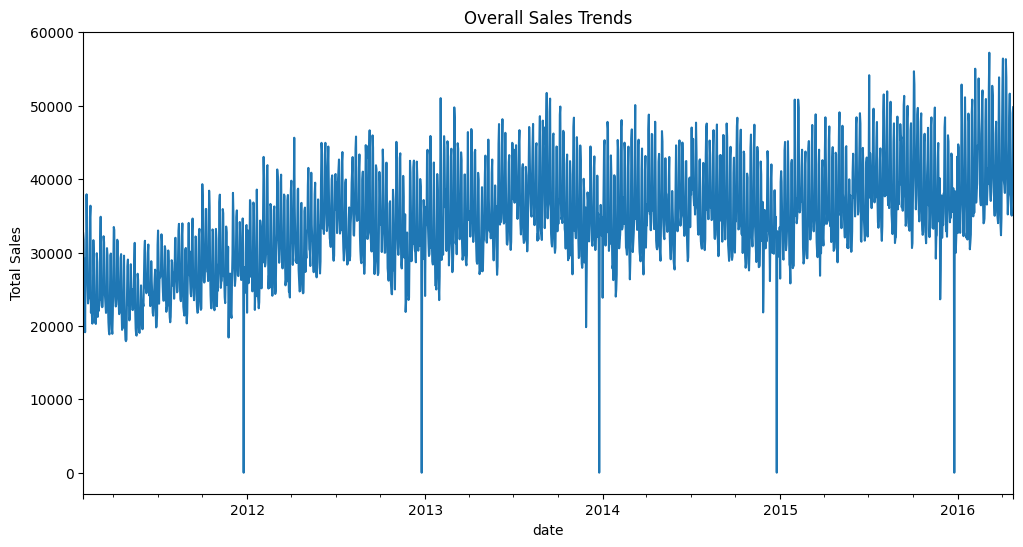

In [27]:

# This graph is about overall sales trend, but in every year there is a day where there are no sales
sales_with_prices.groupby('date')['sales'].sum().plot(figsize=(12, 6), title="Overall Sales Trends", ylabel="Total Sales")
plt.show()


In [28]:
sales_with_prices.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_7', 'lag_28',
       'rolling_mean_7', 'day_of_week', 'price_diff'],
      dtype='object')

In [29]:
# Every year Foods sales are out performing where hobbies sales at least
cat_sales = sales_with_prices.groupby(['date', 'cat_id'])['sales'].sum().reset_index()
fig = px.line(cat_sales, x='date', y='sales', color='cat_id',
              title="Category-Level Sales Trends")
fig.update_layout(yaxis_title="Total Sales", xaxis_title="Date")
fig.show()

In [30]:
# In the below graph Foods_3 department is outperforming where hobbies_2 is least performer

dept_sales = sales_with_prices.groupby(['date', 'dept_id'])['sales'].sum().reset_index()
fig = px.line(dept_sales, x='date', y='sales', color='dept_id',
              title="Department-Level Sales Trends")
fig.update_layout(yaxis_title="Total Sales", xaxis_title="Date")
fig.show()

In [31]:
state_sales = sales_with_prices.groupby(['date', 'state_id'])['sales'].sum().reset_index()
fig = px.line(state_sales, x='date', y='sales', color='state_id',
              title="State-wise Sales Trends")
fig.update_layout(yaxis_title="Total Sales", xaxis_title="Date")
fig.show()

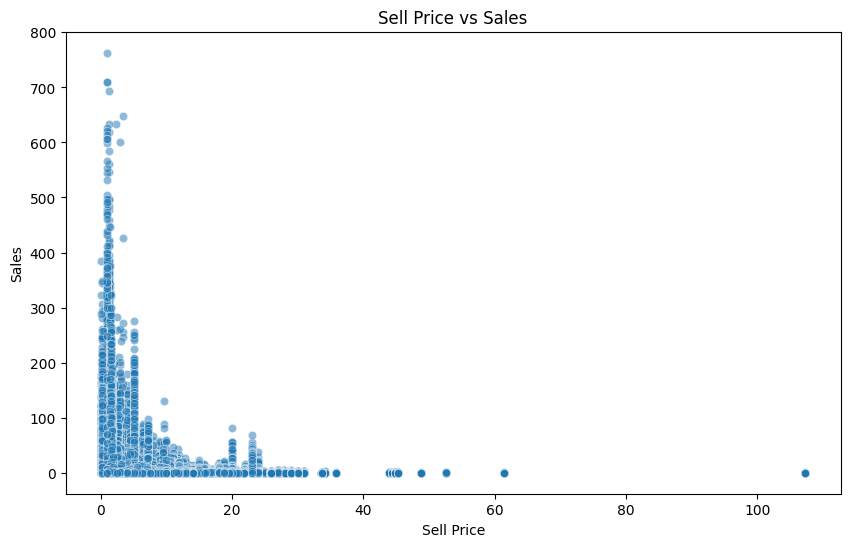

Correlation between Sell Price and Sales:
            sell_price    sales
sell_price     1.00000 -0.15092
sales         -0.15092  1.00000


In [32]:
# In this we can observe negative correlation b/w sales and sell price and most of the units are sold b/w 0 to 20 dollars. Highest units being sold b/1 0 adn 1 dollar
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sell_price', y='sales', data=sales_with_prices, alpha=0.5)
plt.title("Sell Price vs Sales")
plt.xlabel("Sell Price")
plt.ylabel("Sales")
plt.show()

# Correlation between Price and Sales
correlation = sales_with_prices[['sell_price', 'sales']].corr()
print("Correlation between Sell Price and Sales:")
print(correlation)


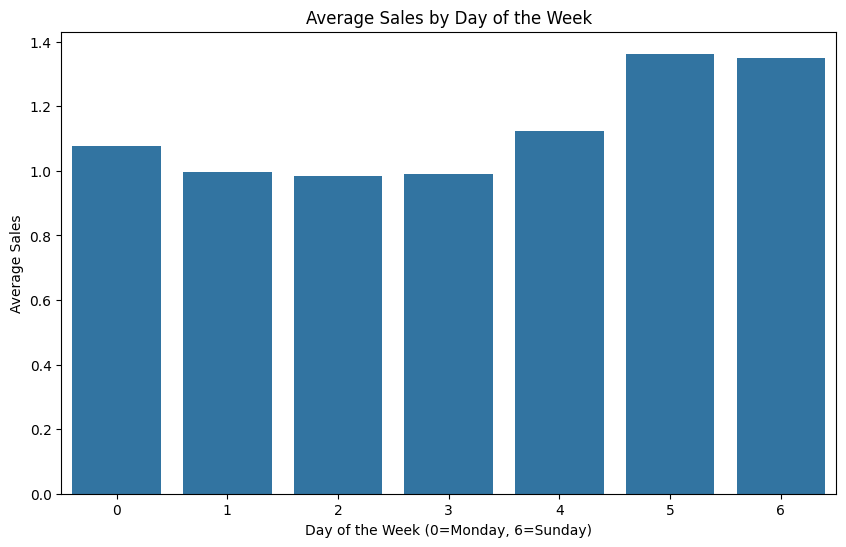

In [33]:
# Average Sales are starting by friday and getting peek at saturday
dow_sales = sales_with_prices.groupby('day_of_week')['sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='sales', data=dow_sales)
plt.title("Average Sales by Day of the Week")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Average Sales")
plt.show()


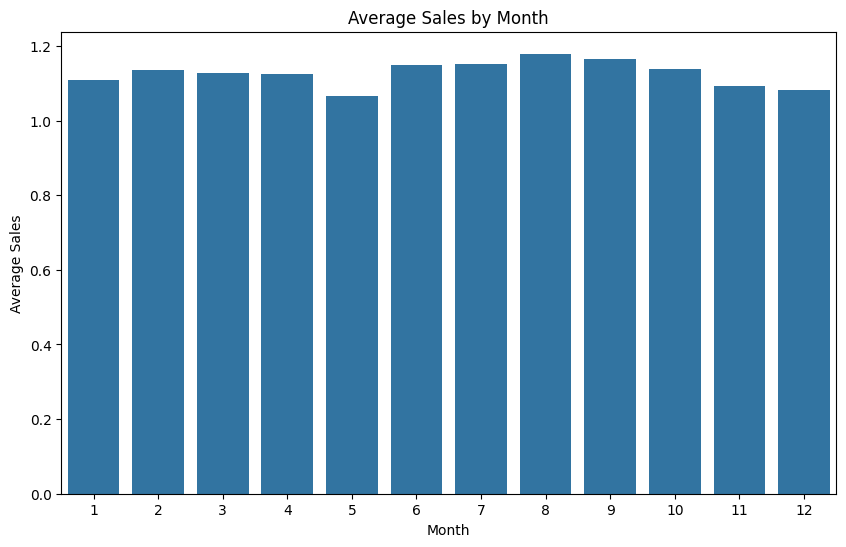

In [34]:
# Month-Wise Sales Trends
month_sales = sales_with_prices.groupby('month')['sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='sales', data=month_sales)
plt.title("Average Sales by Month")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.show()


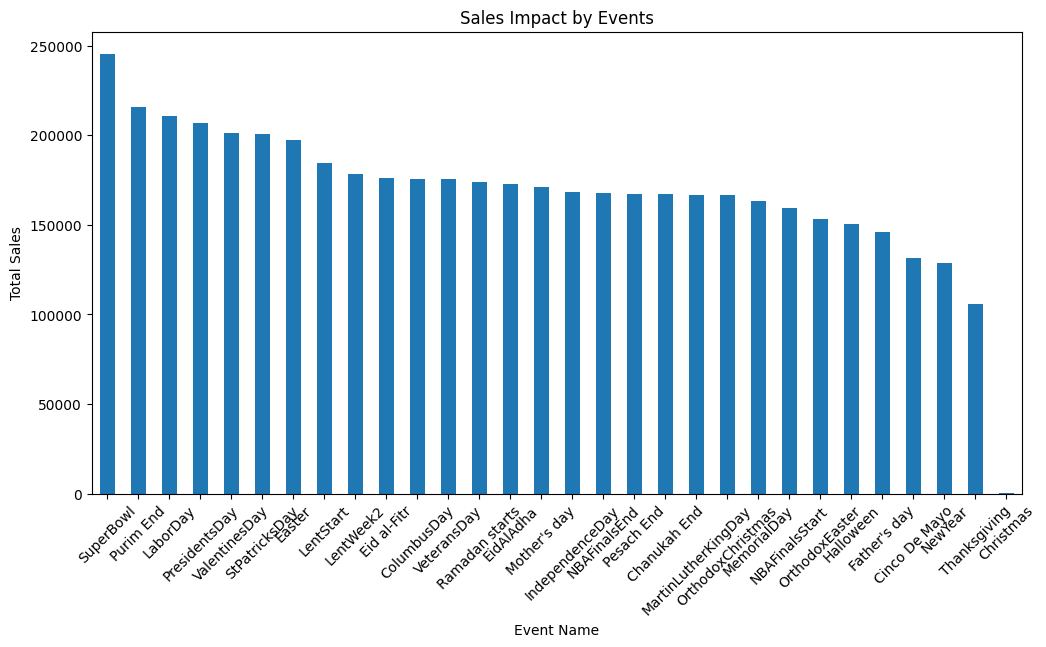

In [35]:
# Event-wise Sales Impact
event_sales = sales_with_prices[sales_with_prices['event_name_1'].notnull()]
event_sales_grouped = event_sales.groupby('event_name_1')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
event_sales_grouped.plot(kind='bar')
plt.title("Sales Impact by Events")
plt.xlabel("Event Name")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()


Average Sales for snap_CA:
snap_CA
0    1.095720
1    1.188643
Name: sales, dtype: float64

Average Sales for snap_TX:
snap_TX
0    1.090948
1    1.198361
Name: sales, dtype: float64

Average Sales for snap_WI:
snap_WI
0    1.090185
1    1.199916
Name: sales, dtype: float64



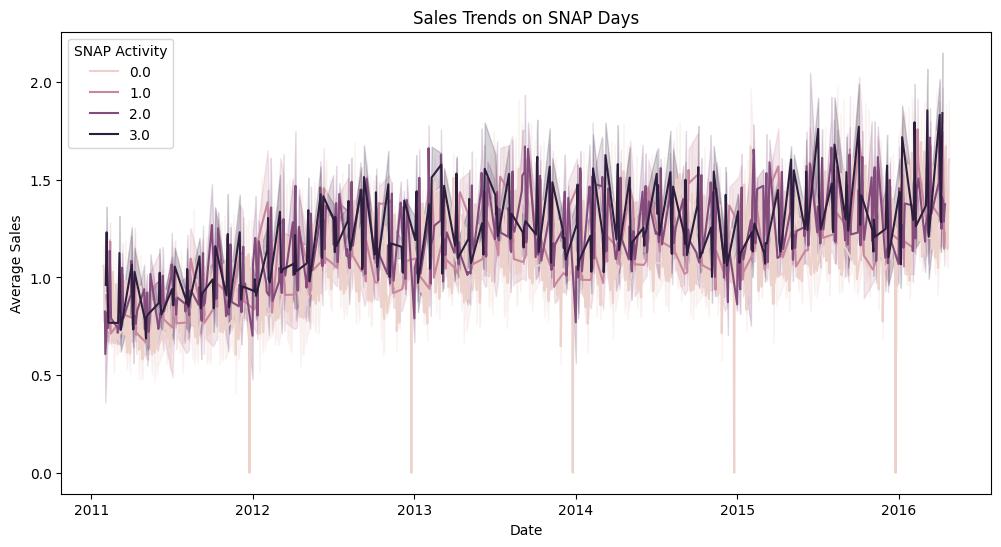

In [36]:
# Analyzing SNAP Day Sales
snap_columns = ['snap_CA', 'snap_TX', 'snap_WI']

for snap in snap_columns:
    snap_sales = sales_with_prices.groupby(snap)['sales'].mean()
    print(f"Average Sales for {snap}:")
    print(snap_sales)
    print()

# Visualize Sales on SNAP Days
snap_sales = sales_with_prices.groupby(['date', 'state_id'])[['snap_CA', 'snap_TX', 'snap_WI', 'sales']].mean().reset_index()
snap_sales['snap_sum'] = snap_sales[['snap_CA', 'snap_TX', 'snap_WI']].sum(axis=1)

plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='sales', hue='snap_sum', data=snap_sales)
plt.title("Sales Trends on SNAP Days")
plt.xlabel("Date")
plt.ylabel("Average Sales")
plt.legend(title="SNAP Activity")
plt.show()


<ipython-input-37-a5b68ad97ef4>:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



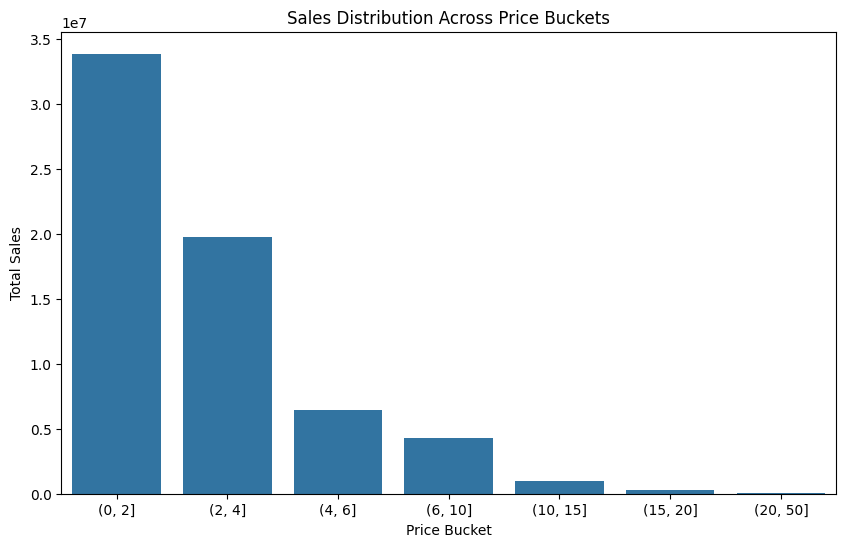

In [37]:
# Creating Price Buckets
sales_with_prices['price_bucket'] = pd.cut(sales_with_prices['sell_price'], bins=[0, 2, 4, 6, 10, 15, 20, 50])

# Analyze Sales by Price Bucket
price_bucket_sales = sales_with_prices.groupby('price_bucket')['sales'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='price_bucket', y='sales', data=price_bucket_sales)
plt.title("Sales Distribution Across Price Buckets")
plt.xlabel("Price Bucket")
plt.ylabel("Total Sales")
plt.show()


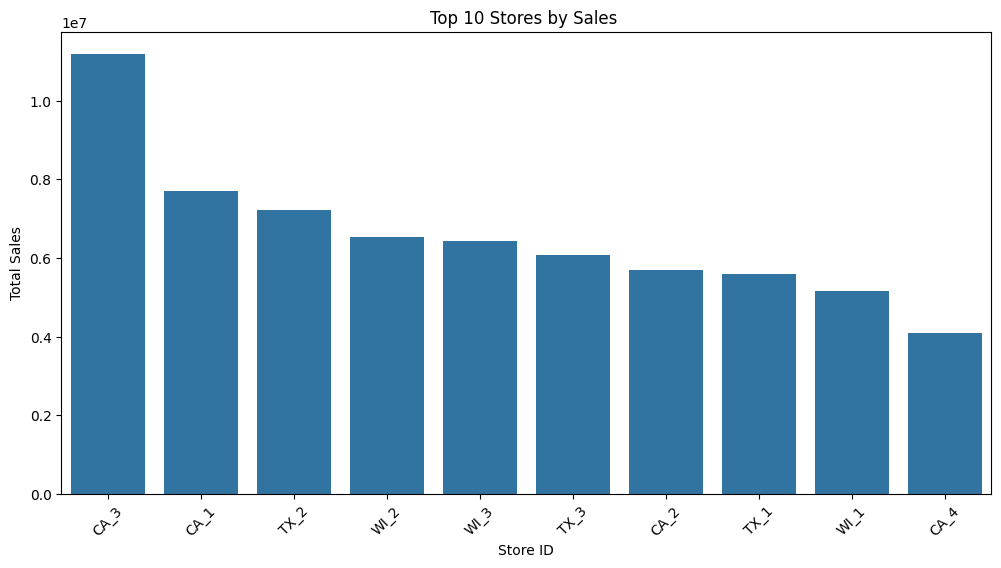

In [38]:
# Store-Level Sales
store_sales = sales_with_prices.groupby('store_id')['sales'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='store_id', y='sales', data=store_sales.head(10))
plt.title("Top 10 Stores by Sales ")
plt.xlabel("Store ID")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()


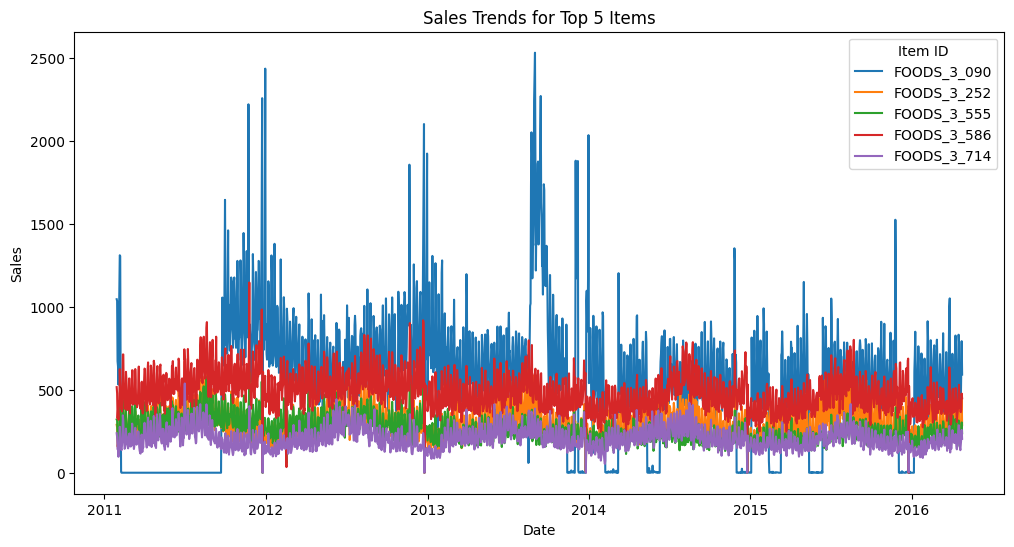

In [39]:
# Top 5 Items by Total Sales
top_items = sales_with_prices.groupby('item_id')['sales'].sum().sort_values(ascending=False).head(5).index

# Filter Data for Top Items
top_item_sales = sales_with_prices[sales_with_prices['item_id'].isin(top_items)]
top_item_sales_grouped = top_item_sales.groupby(['date', 'item_id'])['sales'].sum().reset_index()

# Plot Trends for Top Items
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='sales', hue='item_id', data=top_item_sales_grouped)
plt.title("Sales Trends for Top 5 Items")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(title="Item ID")
plt.show()


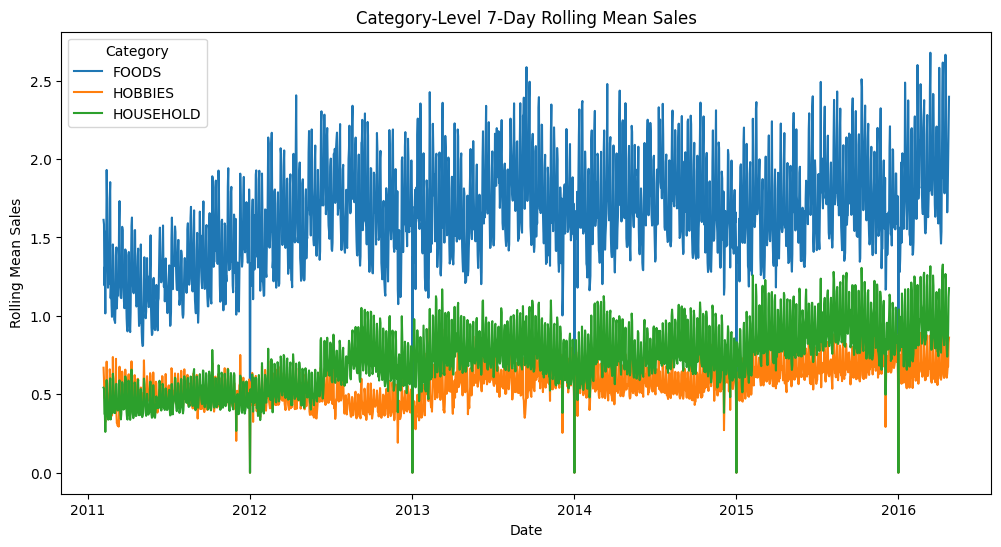

In [40]:

# Moving Average Feature at Category Level
rolling_cat_sales = sales_with_prices.groupby(['date', 'cat_id'])['rolling_mean_7'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='rolling_mean_7', hue='cat_id', data=rolling_cat_sales)
plt.title("Category-Level 7-Day Rolling Mean Sales")
plt.xlabel("Date")
plt.ylabel("Rolling Mean Sales")
plt.legend(title="Category")
plt.show()

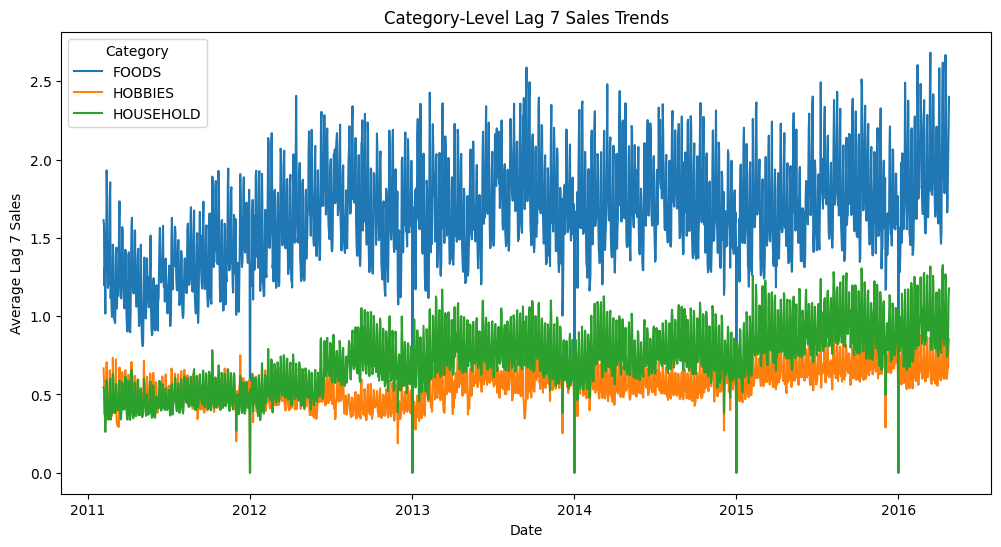

In [41]:


# Lag Feature - Rolling Average Visualized at Category Level
lag_cat_sales = sales_with_prices.groupby(['date', 'cat_id'])['lag_7'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='lag_7', hue='cat_id', data=lag_cat_sales)
plt.title("Category-Level Lag 7 Sales Trends")
plt.xlabel("Date")
plt.ylabel("Average Lag 7 Sales")
plt.legend(title="Category")
plt.show()


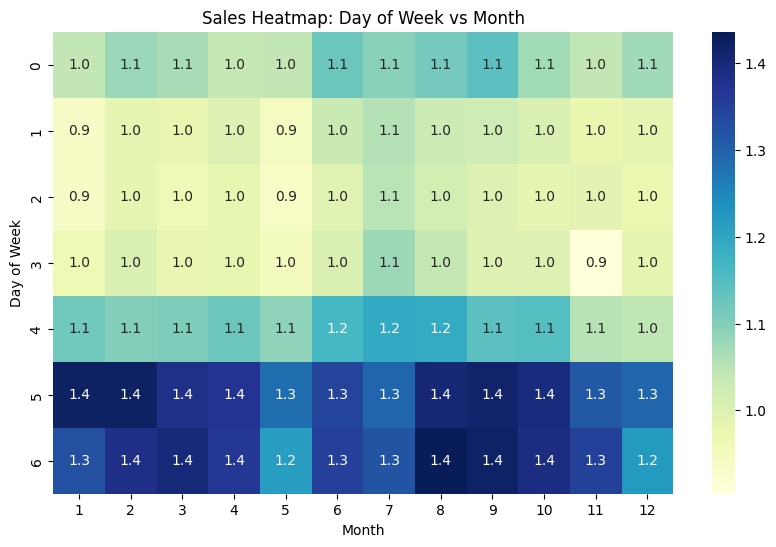

In [42]:
heatmap_data = sales_with_prices.groupby(['day_of_week', 'month'])['sales'].mean().unstack()
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Sales Heatmap: Day of Week vs Month")
plt.xlabel("Month")
plt.ylabel("Day of Week")
plt.show()

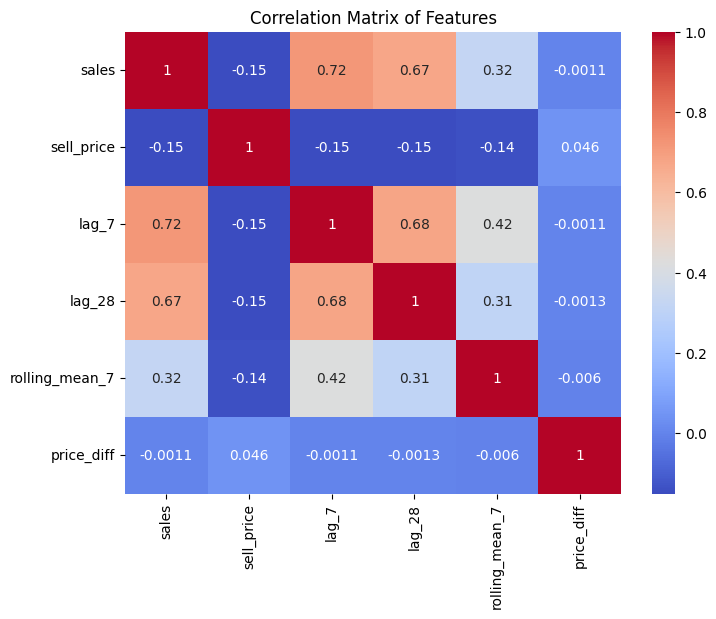

In [43]:
# Correlation Matrix for Numerical Features
correlation_matrix = sales_with_prices[['sales', 'sell_price', 'lag_7', 'lag_28', 'rolling_mean_7', 'price_diff']].corr()

# Plot Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Features")
plt.show()


# Model Building

### 1. Prepare the Data
### 2. Feature Engineering
### 3. Forecasting Models
### 4. Model Training and Validation




## Categories Level: Forecast the total units for each of the three categories (Hobbies, Household, Foods) across all stores in Texas.

### 1. Prepare the Data
Filtered Data for Texas: Focus on state_id == 'TX' as specified.
Aggregate Sales:
Category Level: Use cat_id and group by dates.
Department Level: Use dept_id and group by dates.
Train/Validation Split:
Use data up to d_1913 for training.
Leave d_1914 to d_1941 for prediction.

In [44]:
state_choose = 'TX'
sales_tx = sales_with_prices[sales_with_prices['state_id'] == state_choose]
category_sales = sales_tx.groupby(['date', 'cat_id'])['sales'].sum().reset_index()
# department_sales = sales_tx.groupby(['date', 'dept_id'])['sales'].sum().reset_index()

last_training_date = '2016-04-24'  # d_1913
forecast_dates = pd.date_range(start='2016-04-25', periods=28)  # d_1914 to d_1941
unique_categories = category_sales['cat_id'].unique()


## 2. Feature Engineering


Lag Features: Lagged sales to capture previous trends.
lag_7, lag_14, lag_28 (previous weeks).
Rolling Window Features:
7-day and 28-day rolling means (rolling_mean_7, rolling_mean_28).
Calendar Features:
Day of the week (day_of_week), month (month), and event features.
Price Features:
Latest sell_price, price differences, or promotions.
SNAP Days:
Use snap_TX as a feature.

In [45]:
def create_features(df, group_col, lags=[7, 28], rolling_windows=[7, 28]):
    df['date'] = pd.to_datetime(df['date'])
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby(group_col)['sales'].shift(lag)
    for window in rolling_windows:
        df[f'rolling_mean_{window}'] = (
            df.groupby(group_col)['sales'].shift(7).rolling(window).mean()
        )
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    return df


## 3. Baseline Model
    Baseline Model: The naive_forecast function generates a simple baseline forecast
     

In [46]:
def naive_forecast(df, group_col, forecast_dates):
    last_28_days = df[df['date'] > (pd.to_datetime(last_training_date) - pd.Timedelta(days=28))]
    mean_sales = last_28_days.groupby(group_col)['sales'].mean().reset_index()
    mean_sales.columns = [group_col, 'Naive Forecast']

    forecast_df = pd.DataFrame({
        'date': np.repeat(forecast_dates, len(mean_sales)),
        group_col: np.tile(mean_sales[group_col], len(forecast_dates))
    })
    forecast_df = forecast_df.merge(mean_sales, on=group_col, how='left')
    return forecast_df

## 4. Model Training and Validation
Split data into Train (d_1 to d_1913) and Validation (d_1886 to d_1913 for validation).
chose rmse, mse, r^2 as metrics

### GBM models

In [74]:
def train_model(X_train, y_train, X_valid, y_valid, model_type='lgbm'):
    if model_type == 'lgbm':
        model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, reg_alpha=0.1, reg_lambda=0.5)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            callbacks=[early_stopping(stopping_rounds=50, verbose=1)]
        )
    elif model_type == 'xgb':
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)
        params = {
            'objective': 'reg:squarederror',
            'learning_rate': 0.05,
            'alpha': 0.1,  # L1 regularization
            'lambda': 1.0, # L2 regularization
            'eval_metric': 'rmse'
        }
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=1000,  # Total boosting rounds
            evals=[(dvalid, 'validation')],
            early_stopping_rounds=50,
            verbose_eval=1
        )
    return model


In [48]:
category_sales = create_features(category_sales, group_col='cat_id')

# Validation Results for Each Category and Both Models
validation_results = []
categories = category_sales['cat_id'].unique()

for category in categories:
    print(f"Processing Category: {category}")
    cat_df = category_sales[category_sales['cat_id'] == category]

    # Split Data
    X = cat_df.dropna()[['lag_7', 'lag_28', 'rolling_mean_7', 'rolling_mean_28', 'day_of_week', 'month']]
    y = cat_df.dropna()['sales']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train LightGBM Model
    model_lgbm = train_model(X_train, y_train, X_valid, y_valid, model_type='lgbm')
    y_pred_lgbm = model_lgbm.predict(X_valid)

    # Train XGBoost Model
    model_xgb = train_model(X_train, y_train, X_valid, y_valid, model_type='xgb')
    dvalid = xgb.DMatrix(X_valid)
    y_pred_xgb = model_xgb.predict(dvalid)

    # Create Validation Results DataFrame
    val_df = pd.DataFrame({
        'date': pd.date_range(start=cat_df['date'].iloc[len(X_train)], periods=len(y_valid)),
        'cat_id': category,
        'Actual': y_valid.values,
        'LightGBM': y_pred_lgbm,
        'XGBoost': y_pred_xgb
    })
    validation_results.append(val_df)

# Combine Validation Results for All Categories
validation_df = pd.concat(validation_results)


Processing Category: FOODS
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1040
[LightGBM] [Info] Number of data points in the train set: 1508, number of used features: 6
[LightGBM] [Info] Start training from score 6772.653846
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	valid_0's l2: 738737
[0]	validation-rmse:1196.40740
[1]	validation-rmse:1165.17158
[2]	validation-rmse:1138.94625
[3]	validation-rmse:1114.51385
[4]	validation-rmse:1090.88907
[5]	validation-rmse:1069.80889
[6]	validation-rmse:1050.66291
[7]	validation-rmse:1032.71880
[8]	validation-rmse:1015.11937
[9]	validation-rmse:999.39431
[10]	validation-rmse:986.32374
[11]	validation-rmse:973.54569
[12]	validation-rmse:962.25165
[13]	validation-rmse:952.78324
[14]	validation-rmse:942.97561
[15]	validation-rmse:934.99988
[16]	validati

In [49]:

# Define color mapping for each category
category_colors = {
    'HOBBIES': {'Actual': 'blue', 'LightGBM': 'orange', 'XGBoost': 'green'},
    'HOUSEHOLD': {'Actual': 'purple', 'LightGBM': 'red', 'XGBoost': 'darkgreen'},
    'FOODS': {'Actual': 'navy', 'LightGBM': 'darkorange', 'XGBoost': 'darkolivegreen'}
}

# Plot Validation Results for Each Category
fig = go.Figure()

for category in categories:
    cat_valid = validation_df[validation_df['cat_id'] == category]

    # Plot Actual Sales
    fig.add_trace(go.Scatter(
        x=cat_valid['date'],
        y=cat_valid['Actual'],
        mode='lines+markers',
        name=f'Category {category} Actual',
        line=dict(color=category_colors[category]['Actual'])
    ))

    # Plot LightGBM Predictions
    fig.add_trace(go.Scatter(
        x=cat_valid['date'],
        y=cat_valid['LightGBM'],
        mode='lines+markers',
        name=f'Category {category} LightGBM',
        line=dict(color=category_colors[category]['LightGBM'], dash='dot')
    ))

    # Plot XGBoost Predictions
    fig.add_trace(go.Scatter(
        x=cat_valid['date'],
        y=cat_valid['XGBoost'],
        mode='lines+markers',
        name=f'Category {category} XGBoost',
        line=dict(color=category_colors[category]['XGBoost'], dash='dot')
    ))

# Layout
fig.update_layout(
    title="Validation Results: Actual vs LightGBM vs XGBoost for Categories",
    xaxis_title="Date",
    yaxis_title="Sales",
    hovermode="x unified",
    template="plotly_white",
    height=600
)

fig.show()


In [50]:
metrics_results = {'Category': [], 'Model': [], 'RMSE': [], 'MSE': [], 'R2': []}

# Calculate Metrics for Each Category
for category in categories:
    cat_valid = validation_df[validation_df['cat_id'] == category]

    # Actual vs LightGBM
    rmse_lgbm = np.sqrt(mean_squared_error(cat_valid['Actual'], cat_valid['LightGBM']))
    mse_lgbm = mean_squared_error(cat_valid['Actual'], cat_valid['LightGBM'])
    r2_lgbm = r2_score(cat_valid['Actual'], cat_valid['LightGBM'])

    # Append LightGBM metrics
    metrics_results['Category'].append(category)
    metrics_results['Model'].append('LightGBM')
    metrics_results['RMSE'].append(rmse_lgbm)
    metrics_results['MSE'].append(mse_lgbm)
    metrics_results['R2'].append(r2_lgbm)

    # Actual vs XGBoost
    rmse_xgb = np.sqrt(mean_squared_error(cat_valid['Actual'], cat_valid['XGBoost']))
    mse_xgb = mean_squared_error(cat_valid['Actual'], cat_valid['XGBoost'])
    r2_xgb = r2_score(cat_valid['Actual'], cat_valid['XGBoost'])

    # Append XGBoost metrics
    metrics_results['Category'].append(category)
    metrics_results['Model'].append('XGBoost')
    metrics_results['RMSE'].append(rmse_xgb)
    metrics_results['MSE'].append(mse_xgb)
    metrics_results['R2'].append(r2_xgb)


# Convert the metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_results)

metrics_df


,Category,Model,RMSE,MSE,R2
0,FOODS,LightGBM,859.498142,738737.056740,0.507719
1,FOODS,XGBoost,900.546041,810983.172179,0.459575
2,HOBBIES,LightGBM,149.864202,22459.278983,0.178640
3,HOBBIES,XGBoost,153.670597,23614.652380,0.136387
4,HOUSEHOLD,LightGBM,371.894508,138305.525266,0.393923
5,HOUSEHOLD,XGBoost,389.340275,151585.849655,0.335726


In [51]:

# Function to Forecast Future Sales for Each Category
def forecast_future_sales(model_lgbm, model_xgb, recent_data, forecast_dates):
    forecast_lgbm, forecast_xgb = [], []
    last_known_data = recent_data.copy()

    for forecast_date in forecast_dates:
        # Generating features dynamically
        lag_7 = last_known_data['sales'].iloc[-7] if len(last_known_data) >= 7 else 0
        lag_28 = last_known_data['sales'].iloc[-28] if len(last_known_data) >= 28 else 0
        rolling_mean_7 = last_known_data['sales'].iloc[-7:].mean() if len(last_known_data) >= 7 else 0
        rolling_mean_28 = last_known_data['sales'].iloc[-28:].mean() if len(last_known_data) >= 28 else 0

        # Create feature row for forecast
        features = pd.DataFrame([{
            'lag_7': lag_7,
            'lag_28': lag_28,
            'rolling_mean_7': rolling_mean_7,
            'rolling_mean_28': rolling_mean_28,
            'day_of_week': forecast_date.dayofweek,
            'month': forecast_date.month
        }])

        # Forecast using both models
        pred_lgbm = model_lgbm.predict(features)[0]
        pred_xgb = model_xgb.predict(features)[0]

        # Append predictions
        forecast_lgbm.append(pred_lgbm)
        forecast_xgb.append(pred_xgb)

        # Update recent data for the next forecast iteration
        next_row = {'date': forecast_date, 'sales': pred_lgbm}
        last_known_data = pd.concat([last_known_data, pd.DataFrame([next_row])], ignore_index=True)

    return forecast_lgbm, forecast_xgb

# Forecasting for Each Category
forecast_results = []
forecast_dates = pd.date_range(start='2016-04-25', periods=28)  # Define future dates
categories = category_sales['cat_id'].unique()

for category in categories:
    print(f"Forecasting for Category: {category}")

    # Filtering and preparing for the category
    cat_df = category_sales[category_sales['cat_id'] == category].dropna()
    recent_data = cat_df[['date', 'sales']].tail(28).reset_index(drop=True)  # Use last 28 days

    # Train models on historical data
    X = cat_df[['lag_7', 'lag_28', 'rolling_mean_7', 'rolling_mean_28', 'day_of_week', 'month']]
    y = cat_df['sales']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)
    model_lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.05).fit(X_train, y_train)
    model_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, objective='reg:squarederror').fit(X_train, y_train)

    # Forecasting future sales
    forecast_lgbm, forecast_xgb = forecast_future_sales(model_lgbm, model_xgb, recent_data, forecast_dates)

    #  results
    forecast_df = pd.DataFrame({
        'date': forecast_dates,
        'cat_id': category,
        'Forecast_LightGBM': forecast_lgbm,
        'Forecast_XGBoost': forecast_xgb
    })
    forecast_results.append(forecast_df)

# Combine Results
forecast_df = pd.concat(forecast_results)

# Plot Forecast Results
fig = go.Figure()

for category in categories:
    cat_forecast = forecast_df[forecast_df['cat_id'] == category]
    # LightGBM Forecast
    fig.add_trace(go.Scatter(
        x=cat_forecast['date'], y=cat_forecast['Forecast_LightGBM'],
        mode='lines+markers', name=f'Category {category} - LightGBM'
    ))
    # XGBoost Forecast
    fig.add_trace(go.Scatter(
        x=cat_forecast['date'], y=cat_forecast['Forecast_XGBoost'],
        mode='lines+markers', name=f'Category {category} - XGBoost', line=dict(dash='dot')
    ))

# Layout
fig.update_layout(
    title="Improved Forecast: LightGBM vs XGBoost for Each Category",
    xaxis_title="Date",
    yaxis_title="Sales Forecast",
    hovermode="x unified",
    template="plotly_white",
    height=600
)
fig.show()


Forecasting for Category: FOODS
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1040
[LightGBM] [Info] Number of data points in the train set: 1508, number of used features: 6
[LightGBM] [Info] Start training from score 6772.653846
Forecasting for Category: HOBBIES
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1040
[LightGBM] [Info] Number of data points in the train set: 1508, number of used features: 6
[LightGBM] [Info] Start training from score 784.956233
Forecasting for Category: HOUSEHOLD
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1040
[LightGBM] [Info]

In [52]:

forecast_df['date'] = pd.to_datetime(forecast_df['date'])
pivot_df = forecast_df.pivot(index='cat_id', columns='date', values='Forecast_LightGBM')
pivot_df.columns = [f'F{i+1}' for i in range(len(pivot_df.columns))]

pivot_df.reset_index(inplace=True)
pivot_df['id'] = pivot_df['cat_id'].str.split('_').str[0] + f'_{state_choose}_validation'

pivot_df = pivot_df.reset_index(drop=True)
cat_final_df = pivot_df[['id'] + [col for col in pivot_df.columns if col != 'id']]
cat_final_df = cat_final_df.drop(columns=['cat_id'], errors='ignore')

cat_final_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_TX_validation,6904.744287,5891.877852,5788.002799,6482.408924,7467.623913,8525.154258,8938.584728,7079.335566,6477.289224,...,7387.481776,8797.095923,9510.212168,6735.766173,7036.341792,6612.878672,6746.355696,6925.503579,8816.063078,8848.156671
1,HOBBIES_TX_validation,678.378940,746.414580,807.182911,802.266129,881.426756,1071.655577,1087.209449,568.148987,708.440771,...,911.829094,961.394025,954.475422,664.452740,680.382691,579.963619,735.103154,867.500361,943.570356,952.865764
2,HOUSEHOLD_TX_validation,2214.652343,2449.703199,2049.166230,2412.389001,2487.735091,3111.782792,2935.459519,2090.785056,2199.148403,...,2359.854915,2783.439785,2527.986900,2071.764791,1788.749217,2048.986726,2003.623322,2435.980817,2589.892105,2413.377966


# LSTM - Categories

In [69]:
# Prepare Data
category_sales = sales_tx.groupby(['date', 'cat_id'])['sales'].sum().reset_index()

category_sales = create_features(category_sales, group_col='cat_id')

# Initialize scalers
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Train and Validate for Each Category
validation_results = []
categories = category_sales['cat_id'].unique()

for category in categories:
    print(f"Training and Validation for Category: {category}")

    # Filter category-specific data
    cat_df = category_sales[category_sales['cat_id'] == category].dropna()

    # Prepare input features and target
    X = cat_df[['lag_7', 'lag_28', 'rolling_mean_7', 'rolling_mean_28', 'day_of_week', 'month']]
    y = cat_df['sales'].values.reshape(-1, 1)

    # Scale the data
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    # Reshape X for LSTM (samples, time steps, features)
    X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Train-validation split
    X_train, X_valid, y_train, y_valid = train_test_split(X_reshaped, y_scaled, test_size=0.2, shuffle=False)

    # Define and train LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=16, verbose=1)

    # Predict on validation set
    y_pred_valid = model.predict(X_valid)
    y_valid_actual = scaler_y.inverse_transform(y_valid)
    y_pred_valid_actual = scaler_y.inverse_transform(y_pred_valid)

    # Store validation results
    val_df = pd.DataFrame({
        'date': cat_df['date'].iloc[-len(y_valid):],
        'cat_id': category,
        'Actual': y_valid_actual.flatten(),
        'LSTM': y_pred_valid_actual.flatten()
    })
    validation_results.append(val_df)

# Combine Validation Results
validation_df = pd.concat(validation_results)

# Plot Validation Results
fig = go.Figure()

for category in categories:
    cat_valid = validation_df[validation_df['cat_id'] == category]
    fig.add_trace(go.Scatter(
        x=cat_valid['date'], y=cat_valid['Actual'],
        mode='lines+markers', name=f'Category {category} Actual'
    ))
    fig.add_trace(go.Scatter(
        x=cat_valid['date'], y=cat_valid['LSTM'],
        mode='lines+markers', name=f'Category {category} LSTM', line=dict(dash='dot')
    ))

fig.update_layout(
    title="Validation Results: Actual vs LSTM for Categories",
    xaxis_title="Date",
    yaxis_title="Sales",
    hovermode="x unified",
    template="plotly_white",
    height=600
)

fig.show()


Training and Validation for Category: FOODS
Epoch 1/100
95/95 [==============================] - 2s 5ms/step - loss: 0.1182 - val_loss: 0.0374
Epoch 2/100
95/95 [==============================] - 0s 3ms/step - loss: 0.0264 - val_loss: 0.0163
Epoch 3/100
95/95 [==============================] - 0s 3ms/step - loss: 0.0146 - val_loss: 0.0108
Epoch 4/100
95/95 [==============================] - 0s 3ms/step - loss: 0.0110 - val_loss: 0.0084
Epoch 5/100
95/95 [==============================] - 0s 3ms/step - loss: 0.0091 - val_loss: 0.0070
Epoch 6/100
95/95 [==============================] - 0s 3ms/step - loss: 0.0088 - val_loss: 0.0064
Epoch 7/100
95/95 [==============================] - 0s 3ms/step - loss: 0.0081 - val_loss: 0.0061
Epoch 8/100
95/95 [==============================] - 0s 3ms/step - loss: 0.0077 - val_loss: 0.0060
Epoch 9/100
95/95 [==============================] - 0s 3ms/step - loss: 0.0076 - val_loss: 0.0057
Epoch 10/100
95/95 [==============================] - 0s 3ms/step

In [54]:
# Forecasting Future Sales for Each Category
forecast_results = []
forecast_dates = pd.date_range(start='2016-04-25', periods=28)

for category in categories:
    print(f"Forecasting for Category: {category}")

    # Filter category-specific data
    cat_df = category_sales[category_sales['cat_id'] == category].dropna()

    # Prepare input features and target
    X = cat_df[['lag_7', 'lag_28', 'rolling_mean_7', 'rolling_mean_28', 'day_of_week', 'month']]
    y = cat_df['sales'].values.reshape(-1, 1)

    # Scale the data
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    # Reshape for LSTM
    X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Train LSTM Model
    X_train, _, y_train, _ = train_test_split(X_reshaped, y_scaled, test_size=0.2, shuffle=False)
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

    # Forecast future sales
    recent_data = X_scaled[-28:]  # Use last 28 rows of scaled features
    recent_data_reshaped = recent_data.reshape((recent_data.shape[0], 1, recent_data.shape[1]))

    forecasts = []
    for i in range(28):
        pred_scaled = model.predict(recent_data_reshaped[-1:])  # Predict next step
        pred = scaler_y.inverse_transform(pred_scaled)[0][0]  # Inverse scale prediction
        forecasts.append(pred)

        # Update recent data
        new_row = np.append(recent_data[-1, 1:], pred_scaled)  # Append prediction as a new row
        recent_data = np.vstack([recent_data, new_row])
        recent_data_reshaped = recent_data.reshape((recent_data.shape[0], 1, recent_data.shape[1]))

    # Store results
    forecast_df = pd.DataFrame({
        'date': forecast_dates,
        'cat_id': category,
        'Forecast_LSTM': forecasts
    })
    forecast_results.append(forecast_df)

# Combine Forecast Results
forecast_df = pd.concat(forecast_results)

Forecasting for Category: FOODS
Epoch 1/100
95/95 [==============================] - 1s 2ms/step - loss: 0.0582
Epoch 2/100
95/95 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 3/100
95/95 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 4/100
95/95 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch 5/100
95/95 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 6/100
95/95 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 7/100
95/95 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 8/100
95/95 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 9/100
95/95 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 10/100
95/95 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 11/100
95/95 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 12/100
95/95 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch

In [55]:

# Plot Forecast Results
fig = go.Figure()

for category in categories:
    cat_forecast = forecast_df[forecast_df['cat_id'] == category]
    fig.add_trace(go.Scatter(
        x=cat_forecast['date'], y=cat_forecast['Forecast_LSTM'],
        mode='lines+markers', name=f'Category {category} LSTM Forecast'
    ))

fig.update_layout(
    title="Forecast Results: LSTM for Each Category",
    xaxis_title="Date",
    yaxis_title="Sales Forecast",
    hovermode="x unified",
    template="plotly_white",
    height=600
)

fig.show()


# Department

In [56]:
department_sales = sales_with_prices.groupby(['date', 'dept_id'])['sales'].sum().reset_index()
department_sales = create_features(department_sales, group_col='dept_id')

# Train and Validate for Each Department
validation_results = []
departments = department_sales['dept_id'].unique()

In [57]:
for department in departments:
    print(f"Training and Validation for Department: {department}")

    # Filter department-specific data
    dept_df = department_sales[department_sales['dept_id'] == department].dropna()

    # Prepare training and validation data
    X = dept_df[['lag_7', 'lag_28', 'rolling_mean_7', 'rolling_mean_28', 'day_of_week', 'month']]
    y = dept_df['sales']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train LightGBM Model
    model_lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.05, reg_alpha=0.1, reg_lambda=0.5)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[early_stopping(50, verbose=1)])
    y_pred_lgbm = model_lgbm.predict(X_valid)

    # Train XGBoost Model
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'alpha': 0.1,
    'lambda': 1.0,
    'eval_metric': 'rmse'
    }

    evals = [(dtrain, 'train'), (dvalid, 'validation')]  # Training and validation sets
    model_xgb = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=50
    )

    y_pred_xgb = model_xgb.predict(dvalid)

    # Store Validation Results
    val_df = pd.DataFrame({
        'date': pd.date_range(start=dept_df['date'].iloc[len(X_train)], periods=len(y_valid)),
        'dept_id': department,
        'Actual': y_valid.values,
        'LightGBM': y_pred_lgbm,
        'XGBoost': y_pred_xgb
    })
    validation_results.append(val_df)

# Combine Validation Results
validation_df = pd.concat(validation_results)

Training and Validation for Department: FOODS_1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1040
[LightGBM] [Info] Number of data points in the train set: 1508, number of used features: 6
[LightGBM] [Info] Start training from score 2575.585544
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	valid_0's l2: 202113
[0]	train-rmse:613.28726	validation-rmse:690.33549
[50]	train-rmse:260.94872	validation-rmse:443.22358
[100]	train-rmse:203.09884	validation-rmse:438.12079
[150]	train-rmse:176.06394	validation-rmse:441.87887
[159]	train-rmse:172.80612	validation-rmse:442.49138
Training and Validation for Department: FOODS_2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

In [58]:
random.seed(42)  # Set seed for reproducibility
department_colors = {
    department: random.choice(pc.qualitative.Plotly)
    for department in departments
}

# Plot Training and Validation Results
fig = go.Figure()

for department in departments:
    dept_valid = validation_df[validation_df['dept_id'] == department]

    # Get color for this department
    dept_color = department_colors[department]

    # Actual Sales
    fig.add_trace(go.Scatter(
        x=dept_valid['date'], y=dept_valid['Actual'],
        mode='lines+markers',
        name=f'Department {department} Actual',
        line=dict(color=dept_color)
    ))

    # LightGBM Predictions
    fig.add_trace(go.Scatter(
        x=dept_valid['date'], y=dept_valid['LightGBM'],
        mode='lines+markers',
        name=f'Department {department} LightGBM',
        line=dict(color=dept_color, dash='dot')
    ))

    # XGBoost Predictions
    fig.add_trace(go.Scatter(
        x=dept_valid['date'], y=dept_valid['XGBoost'],
        mode='lines+markers',
        name=f'Department {department} XGBoost',
        line=dict(color=dept_color, dash='dash')
    ))

# Layout
fig.update_layout(
    title="Training and Validation Results: Actual vs LightGBM vs XGBoost",
    xaxis_title="Date",
    yaxis_title="Sales",
    hovermode="x unified",
    template="plotly_white",
    height=600
)

fig.show()

In [59]:

# Initialized a dictionary to store metrics
metrics_results = {'Department': [], 'Model': [], 'RMSE': [], 'MSE': [], 'R2': []}

# Calculating Metrics for Each Department
for department in departments:
    print(f"Calculating metrics for Department: {department}")

    # Extracted validation data for the department
    dept_valid = validation_df[validation_df['dept_id'] == department]

    # Actual vs LightGBM Predictions
    rmse_lgbm = np.sqrt(mean_squared_error(dept_valid['Actual'], dept_valid['LightGBM']))
    mse_lgbm = mean_squared_error(dept_valid['Actual'], dept_valid['LightGBM'])
    r2_lgbm = r2_score(dept_valid['Actual'], dept_valid['LightGBM'])

    # Append LightGBM metrics
    metrics_results['Department'].append(department)
    metrics_results['Model'].append('LightGBM')
    metrics_results['RMSE'].append(rmse_lgbm)
    metrics_results['MSE'].append(mse_lgbm)
    metrics_results['R2'].append(r2_lgbm)

    # Actual vs XGBoost Predictions
    rmse_xgb = np.sqrt(mean_squared_error(dept_valid['Actual'], dept_valid['XGBoost']))
    mse_xgb = mean_squared_error(dept_valid['Actual'], dept_valid['XGBoost'])
    r2_xgb = r2_score(dept_valid['Actual'], dept_valid['XGBoost'])

    # Append XGBoost metrics
    metrics_results['Department'].append(department)
    metrics_results['Model'].append('XGBoost')
    metrics_results['RMSE'].append(rmse_xgb)
    metrics_results['MSE'].append(mse_xgb)
    metrics_results['R2'].append(r2_xgb)

# Convert the metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_results)
metrics_df

Calculating metrics for Department: FOODS_1
Calculating metrics for Department: FOODS_2
Calculating metrics for Department: FOODS_3
Calculating metrics for Department: HOBBIES_1
Calculating metrics for Department: HOBBIES_2
Calculating metrics for Department: HOUSEHOLD_1
Calculating metrics for Department: HOUSEHOLD_2


,Department,Model,RMSE,MSE,R2
0,FOODS_1,LightGBM,449.570315,2.021135e+05,0.276056
1,FOODS_1,XGBoost,442.491378,1.957986e+05,0.298675
2,FOODS_2,LightGBM,796.133936,6.338292e+05,0.503283
3,FOODS_2,XGBoost,818.614075,6.701290e+05,0.474836
4,FOODS_3,LightGBM,1853.097534,3.433970e+06,0.688944
5,FOODS_3,XGBoost,1914.241725,3.664321e+06,0.668079
6,HOBBIES_1,LightGBM,426.224088,1.816670e+05,0.367183
7,HOBBIES_1,XGBoost,518.520235,2.688632e+05,0.063444
8,HOBBIES_2,LightGBM,81.134987,6.582886e+03,0.432021
9,HOBBIES_2,XGBoost,83.334248,6.944597e+03,0.400812


In [60]:
# Forecasted Future Sales for Each Department
forecast_results = []
forecast_dates = pd.date_range(start='2016-04-25', periods=28)

for department in departments:
    print(f"Forecasting for Department: {department}")

    # Filtered recent data
    dept_df = department_sales[department_sales['dept_id'] == department].dropna()
    recent_data = dept_df[['date', 'sales']].tail(28).reset_index(drop=True)

    # Trained the models
    X = dept_df[['lag_7', 'lag_28', 'rolling_mean_7', 'rolling_mean_28', 'day_of_week', 'month']]
    y = dept_df['sales']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

    model_lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.05).fit(X_train, y_train)
    model_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, objective='reg:squarederror').fit(X_train, y_train)

    # Forecast future sales
    forecast_lgbm, forecast_xgb = [], []
    last_known_data = recent_data.copy()

    for forecast_date in forecast_dates:
        # Generated features dynamically
        lag_7 = last_known_data['sales'].iloc[-7] if len(last_known_data) >= 7 else 0
        lag_28 = last_known_data['sales'].iloc[-28] if len(last_known_data) >= 28 else 0
        rolling_mean_7 = last_known_data['sales'].iloc[-7:].mean() if len(last_known_data) >= 7 else 0
        rolling_mean_28 = last_known_data['sales'].iloc[-28:].mean() if len(last_known_data) >= 28 else 0

        # Create feature row
        features = pd.DataFrame([{
            'lag_7': lag_7, 'lag_28': lag_28,
            'rolling_mean_7': rolling_mean_7, 'rolling_mean_28': rolling_mean_28,
            'day_of_week': forecast_date.dayofweek, 'month': forecast_date.month
        }])

        # Predicted sales
        pred_lgbm = model_lgbm.predict(features)[0]
        pred_xgb = model_xgb.predict(features)[0]

        forecast_lgbm.append(pred_lgbm)
        forecast_xgb.append(pred_xgb)

        # Update recent data
        next_row = {'date': forecast_date, 'sales': pred_lgbm}
        last_known_data = pd.concat([last_known_data, pd.DataFrame([next_row])], ignore_index=True)

    # Storing results
    forecast_df = pd.DataFrame({
        'date': forecast_dates,
        'dept_id': department,
        'Forecast_LightGBM': forecast_lgbm,
        'Forecast_XGBoost': forecast_xgb
    })
    forecast_results.append(forecast_df)

# Combining Forecast results
forecast_df = pd.concat(forecast_results)



Forecasting for Department: FOODS_1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1040
[LightGBM] [Info] Number of data points in the train set: 1508, number of used features: 6
[LightGBM] [Info] Start training from score 2575.585544
Forecasting for Department: FOODS_2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1040
[LightGBM] [Info] Number of data points in the train set: 1508, number of used features: 6
[LightGBM] [Info] Start training from score 3723.596154
Forecasting for Department: FOODS_3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1040
[LightGBM]

In [61]:

# Plot Forecast Results
fig = go.Figure()

for department in departments:
    dept_forecast = forecast_df[forecast_df['dept_id'] == department]

    # LightGBM Forecast
    fig.add_trace(go.Scatter(
        x=dept_forecast['date'], y=dept_forecast['Forecast_LightGBM'],
        mode='lines+markers', name=f'Department {department} - LightGBM'
    ))

    # XGBoost Forecast
    fig.add_trace(go.Scatter(
        x=dept_forecast['date'], y=dept_forecast['Forecast_XGBoost'],
        mode='lines+markers', name=f'Department {department} - XGBoost', line=dict(dash='dot')
    ))

# Layout
fig.update_layout(
    title="Forecast Results: LightGBM vs XGBoost for Each Department",
    xaxis_title="Date",
    yaxis_title="Sales Forecast",
    hovermode="x unified",
    template="plotly_white",
    height=600
)

fig.show()

In [62]:
forecast_df['date'] = pd.to_datetime(forecast_df['date'])  # Ensure date format
pivot_df = forecast_df.pivot(index='dept_id', columns='date', values='Forecast_LightGBM')
pivot_df.columns = [f'F{i+1}' for i in range(len(pivot_df.columns))]

pivot_df.reset_index(inplace=True)
pivot_df['id'] = pivot_df['dept_id'].str.split('-').str[0] + '_validation'

pivot_df = pivot_df.reset_index(drop=True)
dept_final_df = pivot_df[['id'] + [col for col in pivot_df.columns if col != 'id']]
dept_final_df = dept_final_df.drop(columns=['dept_id'], errors='ignore')
dept_final_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_validation,2241.923535,2662.504447,2347.050954,2303.045120,2953.928335,4084.375024,2951.411536,1983.796208,2522.621195,...,2610.135003,4014.679414,2517.800489,1842.965071,2585.129685,2044.004174,1688.703762,2661.716746,3886.432572,2275.446316
1,FOODS_2_validation,4680.008233,4528.700613,4423.007428,4125.115647,5373.594404,5611.665770,5992.309310,4915.446319,5404.993266,...,4715.181478,4914.824274,4871.967546,4764.138598,4474.426463,4526.568780,4408.920818,4423.389738,4382.241079,4580.873062
2,FOODS_3_validation,16801.577020,16168.871205,15840.712083,15823.472832,18115.463839,22954.553814,23047.204163,18208.290300,16240.723497,...,20046.212337,22549.500466,22193.737328,18110.068705,16361.604206,15063.450803,15820.129796,18792.772441,22343.300422,22832.560505
3,HOBBIES_1_validation,2554.112220,2867.688567,2998.068064,2826.905635,3114.998091,3414.958618,3138.902840,2372.851145,2492.121079,...,2860.987954,3152.288192,3226.077479,2311.159669,2173.154707,2197.354266,2354.560601,3043.190498,3182.132011,3067.830765
4,HOBBIES_2_validation,258.934673,357.733883,230.203311,289.097326,406.765438,356.292854,349.013190,192.824991,273.051504,...,228.070035,216.000951,261.920790,198.476366,153.926238,178.219132,195.819280,211.431341,209.557299,256.735242
5,HOUSEHOLD_1_validation,6393.428541,6250.132989,6123.186375,6187.326747,7852.606668,9456.688660,9159.302428,5953.156529,6098.436581,...,6881.373245,9155.977640,9159.302428,6310.712227,6172.280515,5919.650436,5987.980628,6853.029841,9155.977640,9159.302428
6,HOUSEHOLD_2_validation,1589.845653,1621.015540,1524.109707,1655.866491,2103.495965,2290.295873,2265.587489,1746.941807,1565.866106,...,1971.893670,2149.169273,2164.019413,1630.620098,1591.015331,1585.049779,1626.806773,2016.495604,2018.548573,2027.146952


# LSTM - Departments

In [63]:
department_sales = sales_with_prices.groupby(['date', 'dept_id'])['sales'].sum().reset_index()
department_sales = create_features(department_sales, group_col='dept_id')

# Scalers for X and y
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Train and Validate for Each Department
validation_results = []
departments = department_sales['dept_id'].unique()

for department in departments:
    print(f"Training and Validation for Department: {department}")

    # Filter department-specific data
    dept_df = department_sales[department_sales['dept_id'] == department].dropna()

    # Prepare input features and target
    X = dept_df[['lag_7', 'lag_28', 'rolling_mean_7', 'rolling_mean_28', 'day_of_week', 'month']]
    y = dept_df['sales'].values.reshape(-1, 1)

    # Scale the data
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    # Reshape X for LSTM
    X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Train-validation split
    X_train, X_valid, y_train, y_valid = train_test_split(X_reshaped, y_scaled, test_size=0.2, shuffle=False)

    # Define and train LSTM model
    model = Sequential()
    model.add(LSTM(64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01),input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(32, kernel_regularizer=l2(0.01), activation='relu'))
    model.add(Dropout(0.2))  #
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=16, verbose=1)


    # Predict on validation set
    y_pred_valid = model.predict(X_valid)
    y_valid_actual = scaler_y.inverse_transform(y_valid)
    y_pred_valid_actual = scaler_y.inverse_transform(y_pred_valid)

    # Store validation results
    val_df = pd.DataFrame({
        'date': dept_df['date'].iloc[-len(y_valid):],
        'dept_id': department,
        'Actual': y_valid_actual.flatten(),
        'LSTM': y_pred_valid_actual.flatten()
    })
    validation_results.append(val_df)

# Combine Validation Results
validation_df = pd.concat(validation_results)


Training and Validation for Department: FOODS_1
Epoch 1/100
95/95 [==============================] - 3s 7ms/step - loss: 0.5658 - val_loss: 0.1937
Epoch 2/100
95/95 [==============================] - 0s 3ms/step - loss: 0.0951 - val_loss: 0.0466
Epoch 3/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0284 - val_loss: 0.0220
Epoch 4/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0182 - val_loss: 0.0227
Epoch 5/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0168 - val_loss: 0.0178
Epoch 6/100
95/95 [==============================] - 0s 3ms/step - loss: 0.0156 - val_loss: 0.0184
Epoch 7/100
95/95 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.0184
Epoch 8/100
95/95 [==============================] - 0s 3ms/step - loss: 0.0153 - val_loss: 0.0171
Epoch 9/100
95/95 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.0168
Epoch 10/100
95/95 [==============================] - 0s 3ms/

In [64]:
# Plot Validation Results
fig = go.Figure()

for department in departments:
    dept_valid = validation_df[validation_df['dept_id'] == department]
    fig.add_trace(go.Scatter(
        x=dept_valid['date'], y=dept_valid['Actual'],
        mode='lines+markers', name=f'Department {department} Actual'
    ))
    fig.add_trace(go.Scatter(
        x=dept_valid['date'], y=dept_valid['LSTM'],
        mode='lines+markers', name=f'Department {department} LSTM', line=dict(dash='dot')
    ))

fig.update_layout(
    title="Training and Validation Results: Actual vs LSTM",
    xaxis_title="Date",
    yaxis_title="Sales",
    hovermode="x unified",
    template="plotly_white",
    height=600
)

fig.show()

In [65]:
# Forecast Future Sales for Each Department
forecast_results = []
forecast_dates = pd.date_range(start='2016-04-25', periods=28)

for department in departments:
    print(f"Forecasting for Department: {department}")

    # Filter department-specific data
    dept_df = department_sales[department_sales['dept_id'] == department].dropna()

    # Prepare input features
    X = dept_df[['lag_7', 'lag_28', 'rolling_mean_7', 'rolling_mean_28', 'day_of_week', 'month']]
    y = dept_df['sales'].values.reshape(-1, 1)

    # Scale the data
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    # Reshape for LSTM
    X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Use trained model to forecast
    recent_data = X_scaled[-28:]  # Use last 28 rows as starting point
    recent_data_reshaped = recent_data.reshape((recent_data.shape[0], 1, recent_data.shape[1]))

    forecasts = []
    for i in range(28):
        pred_scaled = model.predict(recent_data_reshaped[-1:])  # Predict next step
        pred = scaler_y.inverse_transform(pred_scaled)[0][0]  # Inverse scale prediction
        forecasts.append(pred)

        # Update recent data
        new_row = np.append(recent_data[-1, 1:], pred_scaled)
        recent_data = np.vstack([recent_data, new_row])
        recent_data_reshaped = recent_data.reshape((recent_data.shape[0], 1, recent_data.shape[1]))

    # Store forecast results
    forecast_df = pd.DataFrame({
        'date': forecast_dates,
        'dept_id': department,
        'Forecast_LSTM': forecasts
    })
    forecast_results.append(forecast_df)

# Combine Forecast Results
forecast_df = pd.concat(forecast_results)


Forecasting for Department: FOODS_1
1/1 [==============================] - 0s 24ms/step
Forecasting for Department: FOODS_2
1/1 [==============================] - 0s 25ms/step
Forecasting for Department: FOODS_3
1/1 [==============================] - 0s 24ms/step
Forecasting for Department: HOBBIES_1
1/1 [==============================] - 0s 23ms/step
Forecasting for Department: HOBBIES_2
1/1 [==============================] - 0s 24ms/step
Forecasting for Department: HOUSEHOLD_1
1/1 [==============================] - 0s 23ms/step
Forecasting for Department: HOUSEHOLD_2
1/1 [==============================] - 0s 23ms/step


In [66]:

# Plot Forecast Results
fig = go.Figure()

for department in departments:
    dept_forecast = forecast_df[forecast_df['dept_id'] == department]
    fig.add_trace(go.Scatter(
        x=dept_forecast['date'], y=dept_forecast['Forecast_LSTM'],
        mode='lines+markers', name=f'Department {department} LSTM Forecast'
    ))

fig.update_layout(
    title="Forecast Results: LSTM for Each Department",
    xaxis_title="Date",
    yaxis_title="Sales Forecast",
    hovermode="x unified",
    template="plotly_white",
    height=600
)

fig.show()

In [67]:
metrics_results = {'Department': [], 'Model': [], 'RMSE': [], 'MSE': [], 'R2': []}

# Calculate Metrics for Each Department
for department in departments:

    # Extract validation data for the department
    dept_valid = validation_df[validation_df['dept_id'] == department]

    # Compute Metrics for LSTM
    rmse_lstm = np.sqrt(mean_squared_error(dept_valid['Actual'], dept_valid['LSTM']))
    mse_lstm = mean_squared_error(dept_valid['Actual'], dept_valid['LSTM'])
    r2_lstm = r2_score(dept_valid['Actual'], dept_valid['LSTM'])

    # Append LSTM metrics
    metrics_results['Department'].append(department)
    metrics_results['Model'].append('LSTM')
    metrics_results['RMSE'].append(rmse_lstm)
    metrics_results['MSE'].append(mse_lstm)
    metrics_results['R2'].append(r2_lstm)

# Convering the metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_results)
metrics_df


,Department,Model,RMSE,MSE,R2
0,FOODS_1,LSTM,718.103462,5.156726e+05,-0.847072
1,FOODS_2,LSTM,1757.427599,3.088552e+06,-1.420425
2,FOODS_3,LSTM,3424.892491,1.172989e+07,-0.062516
3,HOBBIES_1,LSTM,883.408682,7.804109e+05,-1.718476
4,HOBBIES_2,LSTM,177.707991,3.158013e+04,-1.724772
5,HOUSEHOLD_1,LSTM,2519.609900,6.348434e+06,-2.002097
6,HOUSEHOLD_2,LSTM,540.049787,2.916538e+05,-1.355137


# Submissions

In [1]:
cat_final_df.to_csv('submission_results.csv', index=False)
dept_final_df.to_csv('submission_results.csv', mode='a', header=False, index=False)

NameError: name 'cat_final_df' is not defined